<a href="https://colab.research.google.com/github/akalakheti/DataAugmentationS4TF/blob/master/DataAugmentationS4TF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%system curl -sL https://github.com/vvmnnnkv/opencv-colab/raw/master/opencv4.tar.gz | tar zxf - -C / && ldconfig /opt/opencv-4.1.0/lib/ && ln -s /opt/opencv-4.1.0/lib/pkgconfig/opencv4.pc /usr/lib/pkgconfig/opencv4.pc

// Install SwiftCV package
%install-location $cwd/swift-packages
%install '.package(url: "https://github.com/vvmnnnkv/SwiftCV.git", .branch("master"))' SwiftCV


Installing packages:
	.package(url: "https://github.com/vvmnnnkv/SwiftCV.git", .branch("master"))
		SwiftCV
With SwiftPM flags: []
Working in: /tmp/tmpgz30p1im/swift-install
Fetching https://github.com/vvmnnnkv/SwiftCV.git
Cloning https://github.com/vvmnnnkv/SwiftCV.git
Resolving https://github.com/vvmnnnkv/SwiftCV.git at master
[1/7] Compiling COpenCV version.cpp
[2/7] Compiling COpenCV imgproc.cpp
[3/7] Compiling COpenCV imgcodecs.cpp
[4/7] Compiling COpenCV core.cpp
[5/10] Compiling SwiftCV TensorFlowConversion.swift
[6/10] Compiling SwiftCV Enums.swift
[7/10] Compiling SwiftCV SwiftCV.swift
[8/11] Merging module SwiftCV
[9/12] Wrapping AST for SwiftCV for debugging
[10/12] Compiling jupyterInstalledPackages jupyterInstalledPackages.swift
[11/13] Merging module jupyterInstalledPackages
[12/13] Wrapping AST for jupyterInstalledPackages for debugging
[13/13] Linking libjupyterInstalledPackages.so
Initializing Swift...
Installation complete!


In [0]:
import TensorFlow

In [0]:
import Python
%include "EnableIPythonDisplay.swift"
IPythonDisplay.shell.enable_matplotlib("inline")
let plt = Python.import("matplotlib.pyplot")
let np = Python.import("numpy")
let pil = Python.import("PIL")
let time = Python.import("time")
let glob = Python.import("glob")
let pilImageOps = Python.import("PIL.ImageOps")
let random = Python.import("random")
let sk = Python.import("skimage")


In [0]:
import Foundation
import FoundationNetworking
let subprocess = Python.import("subprocess")

In [0]:
let command = "wget -nv -O- https://github.com/Ayush517/S4TF-Tutorials/raw/master/cats_and_dogs_filtered.tar.gz | tar xzf - -C ."
subprocess.call(command, shell: true)

2020-01-09 14:42:55 URL:https://raw.githubusercontent.com/Ayush517/S4TF-Tutorials/master/cats_and_dogs_filtered.tar.gz [67304034/67304034] -> "-" [1]


0


In [0]:
func dataAugmentation(pth: String) -> Tensor<Float> {
    var img = pil.Image.open(pth)
    
    if random.randint(0,1) == 1 {
        img = img.rotate(random.randint(1,90)) 
    }
    
    if random.randint(0,1) == 1 {
        img = img.transpose(pil.Image.TRANSPOSE) 
    }
    
    if random.randint(0,1) == 1 {
        img = img.transpose(pil.Image.FLIP_LEFT_RIGHT) 
    }
    
    var image = np.array(img, dtype: np.float32) * (1.0 / 255)
    
    if random.randint(0,1) == 1 {
        image = sk.util.random_noise(image)
    }
    
    image = np.array(image, dtype: np.float32)
    
    let imageTensor = Tensor<Float>(numpy: image)!

    return imageTensor
}

In [0]:
func dataPreps(name: String, isAugmented:Bool) -> (Tensor<Int32>, Tensor<Float>){
  let wholeData = try! FileManager.default.contentsOfDirectory(atPath: "/content/cats_and_dogs_filtered/\(name)/")
  var imageData: [Float] = []
  var labels: [Int32] = []
  var totalImages: Int = 0

  var label: Int32 = 0

    let allImgPath = glob.glob("/content/cats_and_dogs_filtered/\(name)/**/*.jpg")
    
    random.shuffle(allImgPath)
    
    for imagePath in allImgPath{

      let image = pil.Image.open(imagePath).convert("RGB")

      var img = np.array(image, dtype: np.float32) * (1.0 / 255)
      var imageTensor = Tensor<Float>(numpy: img)!
      
      if isAugmented{
        imageTensor = dataAugmentation(pth: String(imagePath)!)
      }
      imageTensor = imageTensor.expandingShape(at: 0)
      imageTensor = _Raw.resizeArea(images: imageTensor , size: [32, 32])
      let label: Int32 = String(imagePath)!.contains("dog.") ? 0 : 1
      labels.append(label)
      imageData.append(contentsOf: imageTensor.scalars)
      totalImages += 1
      
    }
  
  let lbl = Tensor<Int32>(labels)
  let imageTns = Tensor<Float>(
        shape: [totalImages, 32, 32, 3], scalars: imageData)

  return (lbl, imageTns)
}


In [0]:
let test_set = dataPreps(name: "validation" , isAugmented: false )
let train_set = dataPreps(name: "train" , isAugmented: false )

In [0]:
let hiddenSize: Int = 10
let outputClasses: Int = 2
struct Classifier: Layer {
    typealias Input = Tensor<Float>
    typealias Output = Tensor<Float>

    var conv1a = Conv2D<Float>(filterShape: (3, 3, 3, 32), padding: .same, activation: relu)
    var conv1b = Conv2D<Float>(filterShape: (3, 3, 32, 32), activation: relu)
    var pool1 = MaxPool2D<Float>(poolSize: (2, 2), strides: (2, 2))
    var dropout1 = Dropout<Float>(probability: 0.25)
    var conv2a = Conv2D<Float>(filterShape: (3, 3, 32, 64), padding: .same, activation: relu)
    var conv2b = Conv2D<Float>(filterShape: (3, 3, 64, 64), activation: relu)
    var pool2 = MaxPool2D<Float>(poolSize: (2, 2), strides: (2, 2))
    var flatten = Flatten<Float>()
    var dense1 = Dense<Float>(inputSize: 64 * 6 * 6, outputSize: 512, activation: relu)
    var dropout3 = Dropout<Float>(probability: 0.5)
    var dense2 = Dense<Float>(inputSize: 512, outputSize: outputClasses, activation: softmax)

    @differentiable
    func callAsFunction(_ input: Input) -> Output {
        let conv1 = input.sequenced(through: conv1a, conv1b, pool1, dropout1)
        let conv2 = conv1.sequenced(through: conv2a, conv2b, pool2)
        return conv2.sequenced(through: flatten, dense1, dropout3, dense2)
    }

}

In [0]:
let batchSize = 50
func minibatch<Scalar>(in x: Tensor<Scalar>, at index: Int) -> Tensor<Scalar> {
    let initial = index * batchSize
    return x[initial..<initial + batchSize]
}

In [0]:
func visualize(trainAccuracies: [Float], trainLosses: [Float], valAccuracies: [Float], valLosses: [Float], timeSpent: [Float]){
  plt.figure(figsize: [12, 8])
  plt.subplot(1, 2, 1)
  plt.xlabel("Number of Epochs")
  plt.ylabel("Training Accuracy(l) vs Validation Accuracy(o)")
  plt.plot( trainAccuracies)
  plt.plot( valAccuracies)
  var loc = "lower right"
  plt.legend(loc)
  plt.title("Training and Validation Accuracy")

  plt.subplot(1, 2, 2)
  plt.xlabel("Number of Epochs")
  plt.ylabel("Training Loss(u) vs Validation Loss(p)")
  plt.plot(trainLosses)
  plt.plot( valLosses)
  loc = "upper right"
  plt.legend(loc)
  plt.title("Training and Validation Loss")
  plt.show()

  plt.figure(figsize: [12, 8])
  plt.subplot(1, 2, 1)
  plt.xlabel("Number of Epochs")
  plt.ylabel("Time Spent")
  plt.plot(timeSpent)
  loc = "upper right"
  plt.legend(loc)
  plt.title("Time spent per epoch")
  plt.show()

}

In [0]:
func trainer(train_set: (Tensor<Int32>, Tensor<Float>), test_set: (Tensor<Int32>, Tensor<Float>)){
  var classifier = Classifier()
  var optimizer = Adam(for: classifier)
  var trainAccuracies: [Float] = []
  var trainLosses: [Float] = []
  
  var testAccuracies: [Float] = []
  var testLosses: [Float] = []
  var timeSpent: [Float] = []

  for epoch in 1...50 {
      let start = time.time()
      
      let trainImageTensors = train_set.1
      let trainLabelTensors = train_set.0

      let testImageTensors = train_set.1
      let testLabelTensors = train_set.0

      var totalTrainingLoss: Float = 0
      var trainingBatchCount = 0
      var totalTrainingAcc: Int = 0

      var totalTestLoss: Float = 0
      var testBatchCount = 0
      var totalTestAcc: Int = 0
            
      Context.local.learningPhase = .training
      for i in 0..<Int(2000 / batchSize) {
          let x = minibatch(in: trainImageTensors, at: i)
          let y = minibatch(in: trainLabelTensors, at: i)
          // Compute the gradient with respect to the model.
          let grad = classifier.gradient { classifier -> Tensor<Float> in
              let pred = classifier(x)
              let correctPredictions = pred.argmax(squeezingAxis: 1) .== y
              totalTrainingAcc += Int(
                Tensor<Int32>(correctPredictions).sum().scalarized())
              trainingBatchCount += batchSize
              let loss = softmaxCrossEntropy(logits: pred, labels: y)
              totalTrainingLoss += loss.scalarized()
              return loss
          }
          // Update the model's differentiable variables along the gradient vector.
          optimizer.update(&classifier, along: grad)
      }

      Context.local.learningPhase = .inference
      for i in 0..<Int(1000 / batchSize) {
          let x = minibatch(in: testImageTensors, at: i)
          let y = minibatch(in: testLabelTensors, at: i)
          // Compute loss on test set.
          let pred = classifier(x)
          let correctPredictions = pred.argmax(squeezingAxis: 1) .== y
          totalTestAcc += Int(Tensor<Int32>(correctPredictions).sum().scalarized())
          testBatchCount += batchSize
          let loss = softmaxCrossEntropy(logits: pred, labels: y)
          totalTestLoss += loss.scalarized()
      }
      
      let trainAccuracy = Float(totalTrainingAcc) / Float(trainingBatchCount)
      let testAccuracy = Float(totalTestAcc) / Float(testBatchCount)
      
      trainAccuracies.append(trainAccuracy)
      testAccuracies.append(testAccuracy)
      trainLosses.append(totalTrainingLoss)
      testLosses.append(totalTestLoss)
      let time_spent = time.time() - start
      timeSpent.append(Float(time_spent)!)

      
      print("""
            [Epoch \(epoch)] \
            Training Loss: \(totalTrainingLoss), \
            Training Accuracy: \(trainAccuracy), \
            Test Loss: \(totalTestLoss), \
            Test Accuracy: \(testAccuracy), \
            Time Spent: \(Float(time_spent)!)
            """)
  }

  visualize(trainAccuracies: trainAccuracies , trainLosses: trainLosses, valAccuracies: testAccuracies, valLosses: testLosses, timeSpent: timeSpent)

}

[Epoch 1] Training Loss: 27.999508, Training Accuracy: 0.5085, Test Loss: 13.855419, Test Accuracy: 0.54, Time Spent: 2.6966867
[Epoch 2] Training Loss: 27.690664, Training Accuracy: 0.5225, Test Loss: 13.778004, Test Accuracy: 0.555, Time Spent: 1.3609223
[Epoch 3] Training Loss: 27.287062, Training Accuracy: 0.5705, Test Loss: 13.242867, Test Accuracy: 0.629, Time Spent: 1.3472316
[Epoch 4] Training Loss: 26.180475, Training Accuracy: 0.6185, Test Loss: 12.394296, Test Accuracy: 0.698, Time Spent: 1.3162501
[Epoch 5] Training Loss: 25.25258, Training Accuracy: 0.6525, Test Loss: 12.640426, Test Accuracy: 0.662, Time Spent: 1.3453157
[Epoch 6] Training Loss: 24.90524, Training Accuracy: 0.669, Test Loss: 12.219858, Test Accuracy: 0.681, Time Spent: 1.3272471
[Epoch 7] Training Loss: 24.482817, Training Accuracy: 0.676, Test Loss: 11.805337, Test Accuracy: 0.714, Time Spent: 1.3630724
[Epoch 8] Training Loss: 23.823393, Training Accuracy: 0.701, Test Loss: 12.031651, Test Accuracy: 0.7

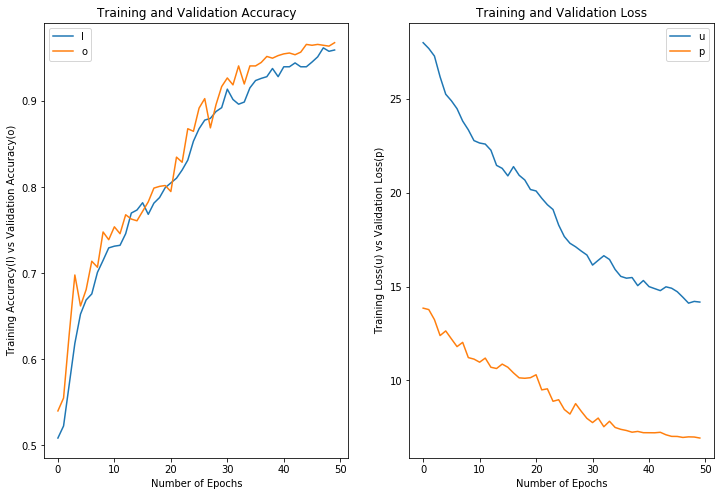

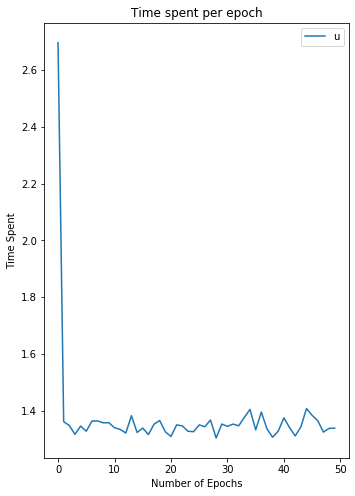

In [0]:
trainer(train_set: train_set , test_set: test_set)

In [0]:
let train_set_augmented = dataPreps(name: "train" , isAugmented: true )
let test_set_augmented = dataPreps(name: "validation" , isAugmented: true )

[Epoch 1] Training Loss: 27.798914, Training Accuracy: 0.505, Test Loss: 13.866402, Test Accuracy: 0.491, Time Spent: 1.3061354
[Epoch 2] Training Loss: 27.731087, Training Accuracy: 0.511, Test Loss: 13.853814, Test Accuracy: 0.535, Time Spent: 1.3304968
[Epoch 3] Training Loss: 27.684334, Training Accuracy: 0.5245, Test Loss: 13.716404, Test Accuracy: 0.63, Time Spent: 1.324867
[Epoch 4] Training Loss: 27.051298, Training Accuracy: 0.585, Test Loss: 13.074954, Test Accuracy: 0.649, Time Spent: 1.3168626
[Epoch 5] Training Loss: 26.529306, Training Accuracy: 0.609, Test Loss: 12.838891, Test Accuracy: 0.636, Time Spent: 1.3595188
[Epoch 6] Training Loss: 25.925735, Training Accuracy: 0.628, Test Loss: 12.592504, Test Accuracy: 0.687, Time Spent: 1.3265371
[Epoch 7] Training Loss: 25.143984, Training Accuracy: 0.6545, Test Loss: 11.713473, Test Accuracy: 0.71, Time Spent: 1.3428822
[Epoch 8] Training Loss: 24.90687, Training Accuracy: 0.6655, Test Loss: 12.473182, Test Accuracy: 0.661,

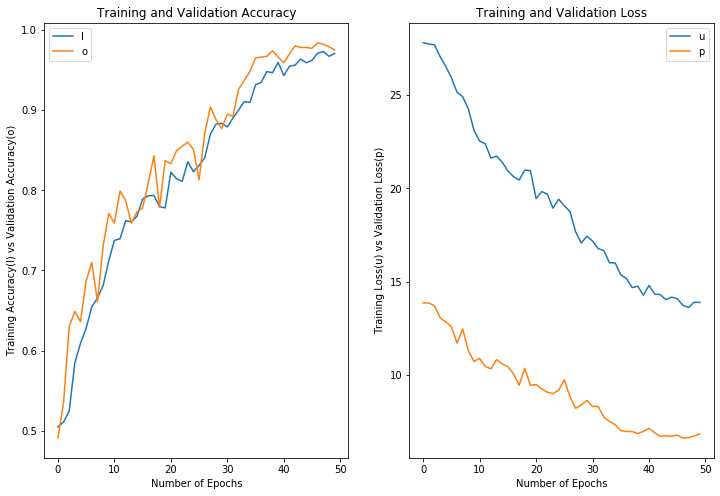

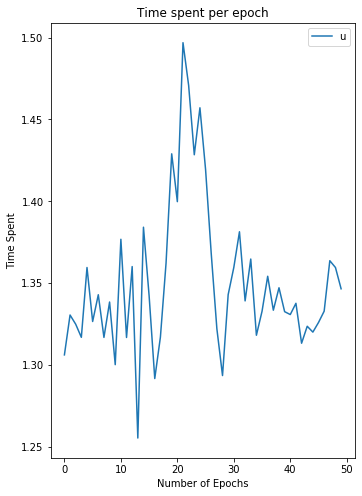

In [0]:
trainer(train_set: train_set_augmented, test_set: test_set_augmented)

In [0]:
import SwiftCV

In [0]:
func dataAugmentationCV(pth: String) -> Tensor<Float> {
    let url = URL(fileURLWithPath: pth)
    let imgContent = try! Data(contentsOf: url)

// make opencv image
    var cvImg = imdecode(imgContent)
// convert color scheme to RGB
    cvImg = cvtColor(cvImg, nil, ColorConversionCode.COLOR_BGR2RGB)
    
    if random.randint(0,1) == 1 {
        let zoomMat = getRotationMatrix2D(Size(cvImg.cols, cvImg.rows / 2), 0, 2)
        cvImg = warpAffine(cvImg, nil, zoomMat, Size(600, 600))
        
    }
    
    if random.randint(0,1) == 1 {
        let rotMat = getRotationMatrix2D(Size(cvImg.cols / 2, cvImg.rows / 2), 20, 1)
        cvImg = warpAffine(cvImg, nil, rotMat, Size(cvImg.cols, cvImg.rows))
    }
    
    if random.randint(0,1) == 1 {
        cvImg = GaussianBlur(cvImg, nil, Size(25, 25))

    }
    if random.randint(0,1) == 1 {
        cvImg = flip(cvImg, nil, FlipMode.HORIZONTAL)
        
    }

    
    let imgTens = Tensor<Float>(Tensor<UInt8>(cvMat: cvImg)!) / 255


    return imgTens
}

In [0]:
func dataPrepsCV(name: String, isAugmented:Bool) -> (Tensor<Int32>, Tensor<Float>){
  let wholeData = try! FileManager.default.contentsOfDirectory(atPath: "/content/cats_and_dogs_filtered/\(name)/")
  var imageData: [Float] = []
  var labels: [Int32] = []
  var totalImages: Int = 0

  var label: Int32 = 0

    let allImgPath = glob.glob("/content/cats_and_dogs_filtered/\(name)/**/*.jpg")
    
    random.shuffle(allImgPath)
    
    for imagePath in allImgPath{

      let image = pil.Image.open(imagePath).convert("RGB")

      var img = np.array(image, dtype: np.float32) * (1.0 / 255)
      var imageTensor = Tensor<Float>(numpy: img)!
      
      if isAugmented{
        imageTensor = dataAugmentationCV(pth: String(imagePath)!)
      }
      imageTensor = imageTensor.expandingShape(at: 0)
      imageTensor = _Raw.resizeArea(images: imageTensor , size: [32, 32])
      let label: Int32 = String(imagePath)!.contains("dog.") ? 0 : 1
      labels.append(label)
      imageData.append(contentsOf: imageTensor.scalars)
      totalImages += 1
      
    }
  
  let lbl = Tensor<Int32>(labels)
  let imageTns = Tensor<Float>(
        shape: [totalImages, 32, 32, 3], scalars: imageData)

  return (lbl, imageTns)
}


In [0]:
let train_data_cv = dataPrepsCV(name: "train" , isAugmented: true )
let test_data_cv = dataPrepsCV(name: "validation" , isAugmented: true )

[Epoch 1] Training Loss: 27.779234, Training Accuracy: 0.516, Test Loss: 13.872234, Test Accuracy: 0.486, Time Spent: 3.089625
[Epoch 2] Training Loss: 27.740652, Training Accuracy: 0.4845, Test Loss: 13.857844, Test Accuracy: 0.516, Time Spent: 1.3536065
[Epoch 3] Training Loss: 27.7325, Training Accuracy: 0.5145, Test Loss: 13.857838, Test Accuracy: 0.487, Time Spent: 1.3198562
[Epoch 4] Training Loss: 27.67255, Training Accuracy: 0.529, Test Loss: 13.785425, Test Accuracy: 0.599, Time Spent: 1.3800879
[Epoch 5] Training Loss: 27.402237, Training Accuracy: 0.5585, Test Loss: 13.690785, Test Accuracy: 0.567, Time Spent: 1.365181
[Epoch 6] Training Loss: 27.148771, Training Accuracy: 0.5805, Test Loss: 13.392853, Test Accuracy: 0.597, Time Spent: 1.3145347
[Epoch 7] Training Loss: 26.882317, Training Accuracy: 0.589, Test Loss: 13.237526, Test Accuracy: 0.597, Time Spent: 1.2547414
[Epoch 8] Training Loss: 27.115414, Training Accuracy: 0.572, Test Loss: 13.328363, Test Accuracy: 0.6, T

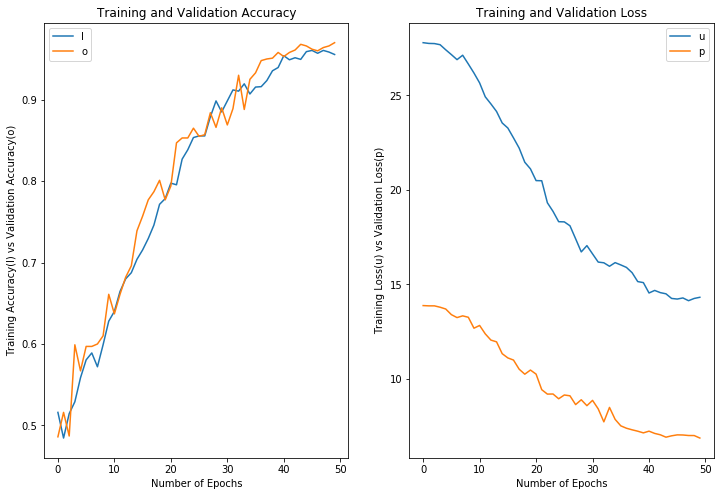

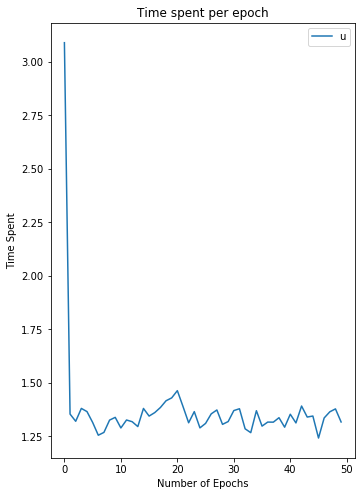

In [0]:
trainer(train_set: train_data_cv , test_set: test_data_cv )